<a href="https://colab.research.google.com/github/manish-anandani/Data-Science-Projects/blob/main/Customer_Segmentation_%5BUnsupervised_Learning%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Customer_Segmentation using Unsupervised learning

At the end of the experiment, you will be able to :

* extract summary level insight from a given customer dataset.

* handle the missing data and identify the underlying pattern or structure of the data.

* create an unsupervised model that generates the optimum number of segments for the customer base

* identify customer segments based on the overall buying behaviour


## Dataset

The dataset chosen for this mini project is the Online Retail dataset. It is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.

The dataset contains 541909 records, and each record is made up of 8 fields.

To know more about the dataset : [click here](https://archive.ics.uci.edu/ml/datasets/Online+Retail)

## Information

**Clustering** is the task of grouping together a set of objects so that the objects in the same cluster are more similar to each other than to objects in other clusters. Similarity is a measure that reflects the strength of the relationship between two data objects.

In the clustering calculation, K-Means is a very popular algorithm. In this analysis, this method is used to cluster the similar data items.

In Retail and E-Commerce (B2C), and more broadly in B2B, one of the key elements shaping the business strategy of a firm is understanding of customer behaviour. More specifically, understanding the customers based on different business metrics: how much they spend (revenue), how often they spend (frequency), are they new or existing customers, what are their favorite products, etc... Such understanding in turn helps direct marketing, sales, account management and product teams to support customers on a personalized level and improve the product offering.

Furthermore, segmenting customers into different categories based on similar/cyclical buying pattern over a period of 1 year helps the retail shops manage their inventory better, thereby lowering costs and raising revenues by placing the orders in sync with the buying cycles.

## Problem Statement

Perform customer segmentation for an Online Retail using an Unsupervised Clustering technique

### Import Required packages

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

## Data Wrangling

In [4]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Online_Retail.zip
!unzip -qq Online_Retail.zip

## Load the data

In [5]:
# YOUR CODE HERE
df_or_train = pd.read_csv('/content/Online_Retail_Train.csv')

In [6]:
def show_df_info(df_temp):
  print(f"The shape of the dataset is : {df_temp.shape}\n")
  print(df_temp.isnull().sum())
  print(f"\nData type info:")
  print("Category type :",list(df_temp.select_dtypes(include=['object']).columns))
  print("Numerical type :",list(df_temp.select_dtypes(include=['float','int']).columns))
  # df_temp.info()
  print()
  print(f"Data frame head: \n")
  print(df_temp.head().to_string())

print(show_df_info(df_or_train))


The shape of the dataset is : (514813, 8)

InvoiceNo           0
StockCode           0
Description      1385
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     128263
Country             0
dtype: int64

Data type info:
Category type : ['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate', 'Country']
Numerical type : ['Quantity', 'UnitPrice', 'CustomerID']

Data frame head: 

  InvoiceNo StockCode                         Description  Quantity          InvoiceDate  UnitPrice  CustomerID         Country
0    579427     22636  CHILDS BREAKFAST SET CIRCUS PARADE         2  2011-11-29 13:04:00       8.50     16479.0  United Kingdom
1    554092     21916     SET 12 RETRO WHITE CHALK STICKS        24  2011-05-22 12:41:00       0.42     17176.0  United Kingdom
2    577774     84692         BOX OF 24 COCKTAIL PARASOLS         6  2011-11-21 15:57:00       0.42     16712.0  United Kingdom
3   C571196     23350             ROLL WRAP VINTAGE SPOT        -12  2011-10-1

## Data Pre-processing (2 points)

Explore the dataset by performing the following operations:

* There is a lot of redundant data. Identify such data and take appropriate action.

  **Hint:** refer to this [link](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html)

* Most Invoices appear as normal transactions with positive quantity and prices, but there are some prefixed with "C" or "A" which denote different transaction types. Invoice starting with C represents cancelled order and A represents the Adjusted. Identify such data and take appropriate action.

  **Hint:** Check the negative values in Quantity column for all cancelled orders

* Handle the null values by dropping or filling with appropriate mean


* Some of the transactions based on the `StockCode` variable are not actually products, but representing the costs or fees regarding to the post or bank or other tansactions. Find such data and handle it accordingly.

  Hint:
    - The transaction with `'POST' 'PADS' 'M' 'DOT' 'C2' 'BANK CHARGES'` as their `StockCodes` are considered as irrelevant transactions.

* Identify the outliers in the UntiPrice and Quantity and handle them accordingly.

  **Hint:** [link](https://kanoki.org/2020/04/23/how-to-remove-outliers-in-python/)

* Create a DayOfWeek column using `InvoiceDate`, Hint: pd.to_datetime()

**Note:** Perform all the above operations using a function to reuse and apply the same for test data.

In [7]:
def data_pre_process(df_temp):
  df_temp = df_temp.copy()
  # Remove duplicates
  df_no_duplicates = df_temp.drop_duplicates()
  # Drop rows with Quantity in negative
  df_temp = df_temp[df_temp['Quantity'] >= 0]

  # Impute Description with common string
  common_string = "No Description Available"
  df_temp['Description'].fillna(common_string, inplace=True)

  # Drop rows with NaN values in CustomerID
  df_temp.dropna(subset=['CustomerID'], inplace=True)

  # Drop rows based on the "StockCode" column containing any of the specified strings in strings_to_check variable
  strings_to_check = ['POST', 'PADS', 'M', 'DOT', 'C2', 'BANK CHARGES']
  df_temp = df_temp[~df_temp['StockCode'].isin(strings_to_check)]

  # Convert CustomerID as categorical columns
  df_temp['CustomerID'] = df_temp['CustomerID'].astype(object)

  return df_temp

def add_dayofweek(df_temp):
  df_temp = df_temp.copy()
  # Convert "InvoiceDate" to datetime data type
  df_temp['InvoiceDate'] = pd.to_datetime(df_temp['InvoiceDate'])
  # Extract the day of the week and store it in a new column "DayOfWeek"
  df_temp['DayOfWeek'] = df_temp['InvoiceDate'].dt.day_name()

  return df_temp

# def cap_outliers(col_name, df_temp):

#   # Calculate the 1st and 99th percentiles
#   lower_bound = df_temp[col_name].quantile(.01)
#   upper_bound = df_temp[col_name].quantile(.99)

#   print(lower_bound, upper_bound)

#   # Cap the lower side outliers
#   df_temp[col_name] = df_temp[col_name].apply(lambda x: max(x, lower_bound))

#   # Cap the upper side outliers
#   df_temp[col_name] = df_temp[col_name].apply(lambda x: min(x, upper_bound))

#   print(df_temp[col_name].value_counts())

#   return df_temp


df_or_train_clean = data_pre_process(df_or_train)
df_or_train_clean = add_dayofweek(df_or_train_clean)


In [8]:
# show_df_info(df_or_train_clean)
print((df_or_train.shape[0] - df_or_train_clean.shape[0])/ df_or_train.shape[0])


0.2683828885439956


In [9]:
# Outlier processing

def cap_outliers(col_name, df_temp):

  df_temp = df_temp.copy()

  # Calculate the 25 and 75 percentiles
  Q1 = df_temp[col_name].quantile(0.25)
  Q3 = df_temp[col_name].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # print(lower_bound, upper_bound)

  # Cap the lower side outliers
  df_temp[col_name] = df_temp[col_name].apply(lambda x: max(x, lower_bound))

  # Cap the upper side outliers
  df_temp[col_name] = df_temp[col_name].apply(lambda x: min(x, upper_bound))

  # print(df_temp[col_name].value_counts())

  return df_temp

col = ['UnitPrice', 'Quantity']

df_or_train_clean = cap_outliers(col[0], df_or_train_clean)
df_or_train_clean = cap_outliers(col[1], df_or_train_clean)


In [10]:
show_df_info(df_or_train_clean)

The shape of the dataset is : (376646, 9)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
DayOfWeek      0
dtype: int64

Data type info:
Category type : ['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Country', 'DayOfWeek']
Numerical type : ['Quantity', 'UnitPrice']

Data frame head: 

  InvoiceNo StockCode                         Description  Quantity         InvoiceDate  UnitPrice CustomerID         Country  DayOfWeek
0    579427     22636  CHILDS BREAKFAST SET CIRCUS PARADE       2.0 2011-11-29 13:04:00       7.50    16479.0  United Kingdom    Tuesday
1    554092     21916     SET 12 RETRO WHITE CHALK STICKS      24.0 2011-05-22 12:41:00       0.42    17176.0  United Kingdom     Sunday
2    577774     84692         BOX OF 24 COCKTAIL PARASOLS       6.0 2011-11-21 15:57:00       0.42    16712.0  United Kingdom     Monday
5    579668     23575             SNACK TRAY PAISLEY PARK       8.0

## Understanding new insights from the data (1 point)

1.  Are there any free items in the data? How many are there?

2.  Find the number of transactions per country and visualize using an appropriate plot

3.  What is the ratio of customers who are repeat purchasers vs single-time purchasers? Visualize using an appropriate plot.

4. Plot heatmap showing unit price per month and day of the week

  **Hint:** Month name as index on Y-axis, Day of the week on X-axis

5. Find the top 10 customers who bought the most no.of items. Also find the top 10 Items bought by most no.of customers.

No of Items for which unit price is 0 are 31



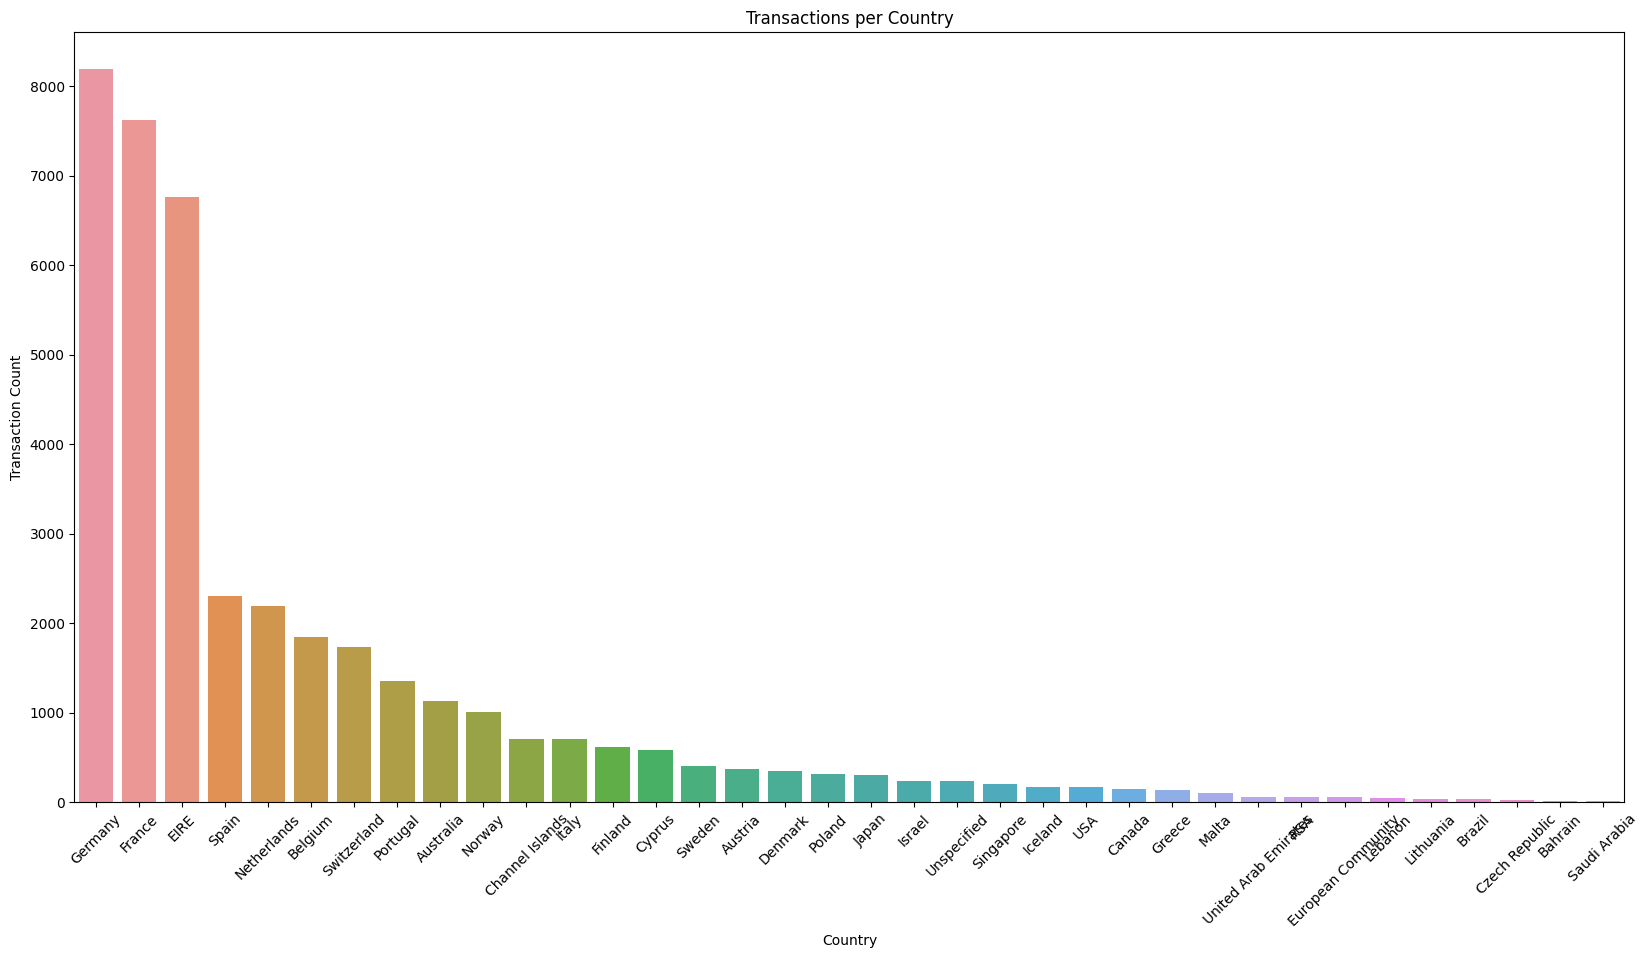

In [11]:
# YOUR CODE HERE
# Items for which unit price is 0
print(f"No of Items for which unit price is 0 are {len(df_or_train_clean[df_or_train_clean['UnitPrice'] == 0])}\n")

# df_or_train_clean_country = df_or_train_clean.Country.value_counts()

# # Calculate the number of transactions per country using value_counts()
transaction_counts = df_or_train_clean['Country'].value_counts().iloc[1:]
transaction_counts.columns = ['Country', 'Transaction Count']

# Create a bar graph using seaborn
plt.figure(figsize=(20, 10))
sns.barplot(x=transaction_counts.index, y=transaction_counts.values)
plt.title('Transactions per Country')
plt.xlabel('Country')
plt.ylabel('Transaction Count')
plt.xticks(rotation=45)
# Show the bar graph
plt.show()

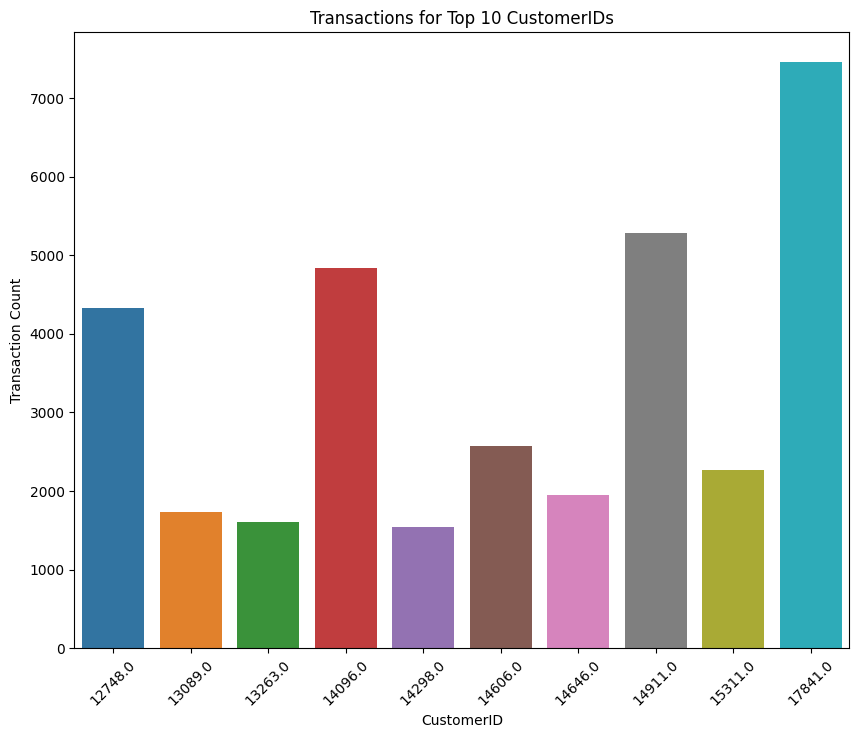

In [12]:
# Top 10 customers by Count of purchases
df_repeat = df_or_train_clean['CustomerID'].value_counts()
df_repeat_cust = pd.DataFrame(df_repeat)

# Create a dataframe with repeat customers

df_repeat_cust['CustomerID'] = df_repeat.index
df_repeat_cust['Count']= df_repeat.values
df_repeat_cust = df_repeat_cust.reset_index(drop=True)

df_repeat_cust['CustomerID'] = df_repeat_cust['CustomerID'].astype(object)

df_top_10_cust = df_repeat_cust.head(10)

# Create a bar graph using seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x=df_top_10_cust.CustomerID, y=df_top_10_cust.Count)
plt.title('Transactions for Top 10 CustomerIDs')
plt.xlabel('CustomerID')
plt.ylabel('Transaction Count')
plt.xticks(rotation=45)
# Show the bar graph
plt.show()

In [13]:
cust_single_purchase = len(df_repeat_cust[df_repeat_cust['Count'] == 1])
cust_multiple_purchases = len(df_repeat_cust[df_repeat_cust['Count'] > 1])

print(f"Single Purchase : {cust_single_purchase} \nMultiple Purchases : {cust_multiple_purchases}")
ratio_single_multiple = (cust_multiple_purchases / (cust_single_purchase+cust_multiple_purchases) * 100)
print(f"Ratio of customers who are repeat purchasers vs single-time purchasers : {ratio_single_multiple}")

Single Purchase : 80 
Multiple Purchases : 4253
Ratio of customers who are repeat purchasers vs single-time purchasers : 98.15370413108701


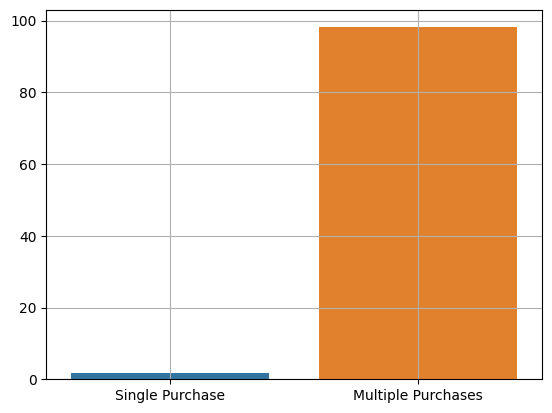

In [14]:
sns.barplot(x=['Single Purchase', 'Multiple Purchases'], y=[100-ratio_single_multiple, ratio_single_multiple])
# plt.yticks(np.arange(0,105,5))
plt.grid(which='both', visible=True)
plt.show()

In [15]:
show_df_info(df_or_train_clean)

The shape of the dataset is : (376646, 9)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
DayOfWeek      0
dtype: int64

Data type info:
Category type : ['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Country', 'DayOfWeek']
Numerical type : ['Quantity', 'UnitPrice']

Data frame head: 

  InvoiceNo StockCode                         Description  Quantity         InvoiceDate  UnitPrice CustomerID         Country  DayOfWeek
0    579427     22636  CHILDS BREAKFAST SET CIRCUS PARADE       2.0 2011-11-29 13:04:00       7.50    16479.0  United Kingdom    Tuesday
1    554092     21916     SET 12 RETRO WHITE CHALK STICKS      24.0 2011-05-22 12:41:00       0.42    17176.0  United Kingdom     Sunday
2    577774     84692         BOX OF 24 COCKTAIL PARASOLS       6.0 2011-11-21 15:57:00       0.42    16712.0  United Kingdom     Monday
5    579668     23575             SNACK TRAY PAISLEY PARK       8.0

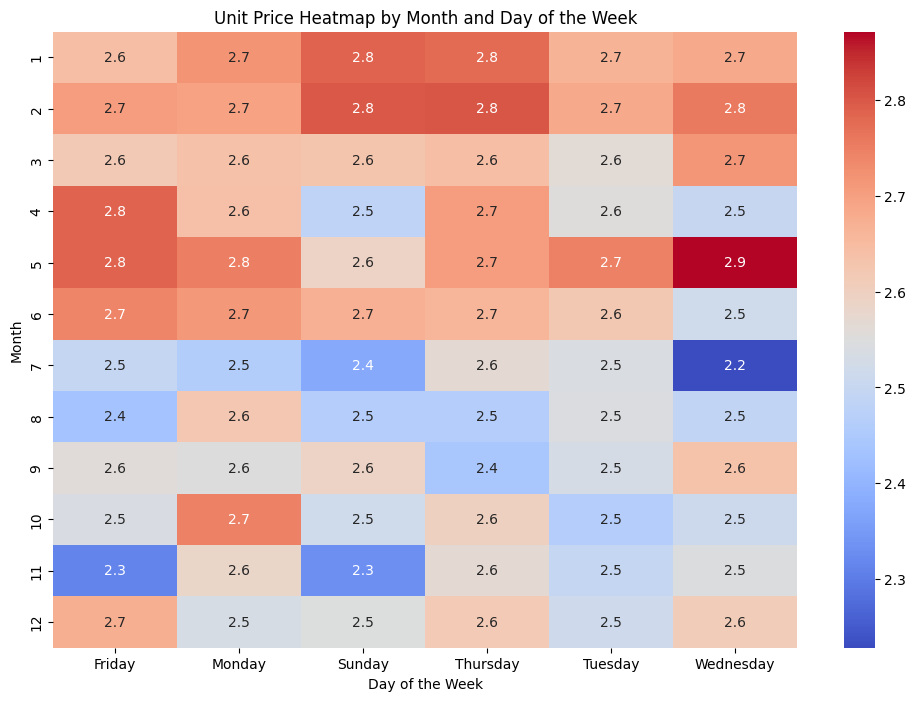

In [16]:
# Extract month and day of the month as separate columns
df_or_train_clean['Month'] = df_or_train_clean['InvoiceDate'].dt.month

# Pivot the DataFrame to prepare it for the heatmap
heatmap_data = df_or_train_clean.pivot_table(values='UnitPrice', index='Month', columns='DayOfWeek', aggfunc='mean')

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".1f", cbar=True)
plt.title('Unit Price Heatmap by Month and Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Month')
plt.show()

df_or_train_clean.drop('Month', axis=1, inplace=True)

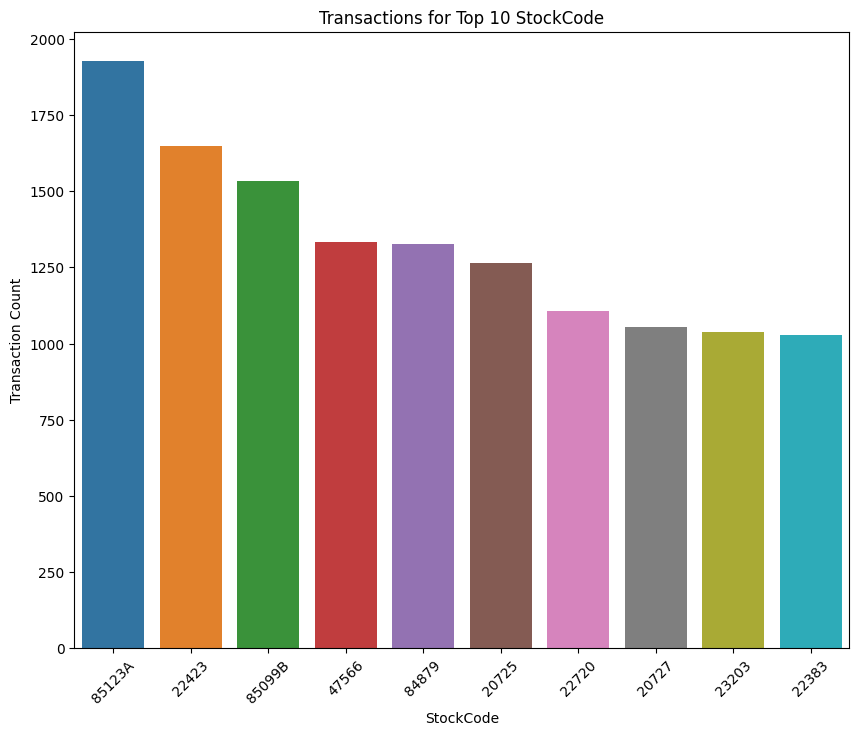

In [17]:
#
df_stock = df_or_train_clean['StockCode'].value_counts()
df_stock_code = pd.DataFrame(df_stock)

# Create a dataframe with repeat customers

df_stock_code['StockCode'] = df_stock.index
df_stock_code['Count']= df_stock.values
df_stock_code = df_stock_code.reset_index(drop=True)

df_stock_code['StockCode'] = df_stock_code['StockCode'].astype(object)

df_top_10_stockcode = df_stock_code.head(10)

# Create a bar graph using seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x=df_top_10_stockcode.StockCode, y=df_top_10_stockcode.Count)
plt.title('Transactions for Top 10 StockCode')
plt.xlabel('StockCode')
plt.ylabel('Transaction Count')
plt.xticks(rotation=45)
# Show the bar graph
plt.show()

In [18]:
# Description of top 10 selling items
df_or_train_clean.iloc[0:10].Description

0     CHILDS BREAKFAST SET CIRCUS PARADE
1        SET 12 RETRO WHITE CHALK STICKS
2            BOX OF 24 COCKTAIL PARASOLS
5                SNACK TRAY PAISLEY PARK
7                 ABC TREASURE BOOK BOX 
8        GIN & TONIC DIET GREETING CARD 
9          CHILDRENS APRON APPLES DESIGN
10    POCKET BAG PINK PAISELY BROWN SPOT
11                         PARTY BUNTING
12     PINK JEWELLED MIRROR TRINKET TRAY
Name: Description, dtype: object

In [19]:
show_df_info(df_or_train_clean)

The shape of the dataset is : (376646, 9)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
DayOfWeek      0
dtype: int64

Data type info:
Category type : ['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Country', 'DayOfWeek']
Numerical type : ['Quantity', 'UnitPrice']

Data frame head: 

  InvoiceNo StockCode                         Description  Quantity         InvoiceDate  UnitPrice CustomerID         Country  DayOfWeek
0    579427     22636  CHILDS BREAKFAST SET CIRCUS PARADE       2.0 2011-11-29 13:04:00       7.50    16479.0  United Kingdom    Tuesday
1    554092     21916     SET 12 RETRO WHITE CHALK STICKS      24.0 2011-05-22 12:41:00       0.42    17176.0  United Kingdom     Sunday
2    577774     84692         BOX OF 24 COCKTAIL PARASOLS       6.0 2011-11-21 15:57:00       0.42    16712.0  United Kingdom     Monday
5    579668     23575             SNACK TRAY PAISLEY PARK       8.0

## Feature Engineering and Transformation (2 points)

### Create new features to uncover better insights and drop the unwanted columns

* Create a new column which represents Total amount spent by each customer

    **Hint:** Quantity * UnitPrice

* Customer IDs are seen to be repeated. Maintain unique customer IDs by grouping and summing up all possible observations per customer.

    **Hint:** [pandas.groupby.agg](https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.core.groupby.DataFrameGroupBy.agg.html)

**Note:** Perform the above operations in function, to reuse and apply the same for test data

In [20]:
# YOUR CODE HERE
def add_new_features(df_temp):
  df_temp = df_temp.copy()

  # Add Total Amount Spent - Monetary
  df_temp['TotalAmountSpent'] = df_temp['Quantity'] * df_temp['UnitPrice']

  # Add Recency - days between max invoice date and last purchase date by customer
  # Step 1: Convert "InvoiceDate" into a datetime format
  df_temp['InvoiceDate'] = pd.to_datetime(df_temp['InvoiceDate'])

  # # Step 3: Calculate the difference between the maximum date and each "InvoiceDate" as recency
  df_max_date = df_temp['InvoiceDate'].max()

  df_temp['Recency'] = df_max_date - df_temp['InvoiceDate']

  # # Step 4: Convert the "Recency" column to integer
  df_temp['Recency'] = df_temp['Recency'].dt.days.astype(int)

  return df_temp

def drop_unwanted_features(df_temp):
  df_temp = df_temp.copy()
  df_temp = df_temp.drop(['InvoiceNo', 'Description','InvoiceDate', 'StockCode','Country','DayOfWeek'], axis=1)
  return df_temp

df_or_train_clean_1 = add_new_features(df_or_train_clean)
df_or_train_clean_1 = drop_unwanted_features(df_or_train_clean_1)

show_df_info(df_or_train_clean_1)

The shape of the dataset is : (376646, 5)

Quantity            0
UnitPrice           0
CustomerID          0
TotalAmountSpent    0
Recency             0
dtype: int64

Data type info:
Category type : ['CustomerID']
Numerical type : ['Quantity', 'UnitPrice', 'TotalAmountSpent', 'Recency']

Data frame head: 

   Quantity  UnitPrice CustomerID  TotalAmountSpent  Recency
0       2.0       7.50    16479.0             15.00        9
1      24.0       0.42    17176.0             10.08      201
2       6.0       0.42    16712.0              2.52       17
5       8.0       1.95    15152.0             15.60        9
7       8.0       2.25    12408.0             18.00      259


In [21]:
# Maintain unique customer IDs by grouping and summing up all possible observations per customer.
df_or_train_rfm = df_or_train_clean_1.groupby('CustomerID').agg({'CustomerID':'count','TotalAmountSpent':'sum','Recency':'min'})
df_or_train_rfm.rename(columns={'CustomerID': 'Frequency', 'TotalAmountSpent': 'Monetary'}, inplace=True)

show_df_info(df_or_train_rfm)

The shape of the dataset is : (4333, 3)

Frequency    0
Monetary     0
Recency      0
dtype: int64

Data type info:
Category type : []
Numerical type : ['Frequency', 'Monetary', 'Recency']

Data frame head: 

            Frequency  Monetary  Recency
CustomerID                              
12346.0             1     28.08      325
12347.0           171   3659.24        1
12348.0            26    482.24       74
12349.0            67   1232.51       18
12350.0            16    294.40      309


In [22]:
# Remove outliers from Monetary column
col=['Frequency', 'Monetary', 'Recency']
df_or_train_rfm_1 = cap_outliers(col[0], df_or_train_rfm)
df_or_train_rfm_2 = cap_outliers(col[1], df_or_train_rfm_1)
df_or_train_rfm_3 = cap_outliers(col[2], df_or_train_rfm_2)

df_or_train_rfm_clean = df_or_train_rfm_3.copy()

show_df_info(df_or_train_rfm_clean)

The shape of the dataset is : (4333, 3)

Frequency    0
Monetary     0
Recency      0
dtype: int64

Data type info:
Category type : []
Numerical type : ['Frequency', 'Monetary', 'Recency']

Data frame head: 

            Frequency  Monetary  Recency
CustomerID                              
12346.0           1.0    28.080    325.0
12347.0         171.0  2974.905      1.0
12348.0          26.0   482.240     74.0
12349.0          67.0  1232.510     18.0
12350.0          16.0   294.400    309.0


In [23]:
df_or_train_rfm_clean

,Frequency,Monetary,Recency
CustomerID,,,
12346.0,1.0,28.080,325.0
12347.0,171.0,2974.905,1.0
12348.0,26.0,482.240,74.0
12349.0,67.0,1232.510,18.0
12350.0,16.0,294.400,309.0
...,...,...,...
18280.0,10.0,174.500,277.0
18281.0,7.0,61.920,180.0
18282.0,11.0,137.460,7.0


<Axes: xlabel='Frequency', ylabel='Count'>

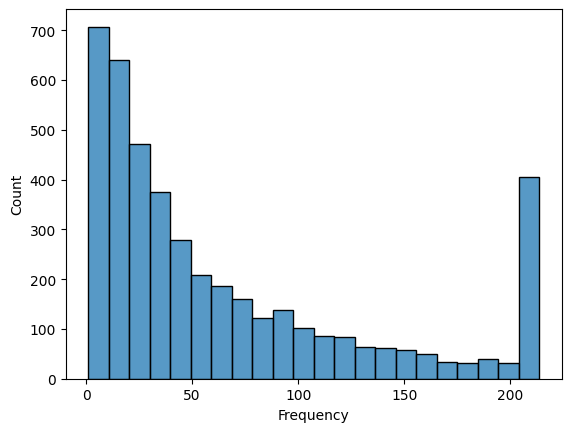

In [24]:
sns.histplot(data=df_or_train_rfm_clean, x='Frequency')

<Axes: xlabel='Monetary', ylabel='Count'>

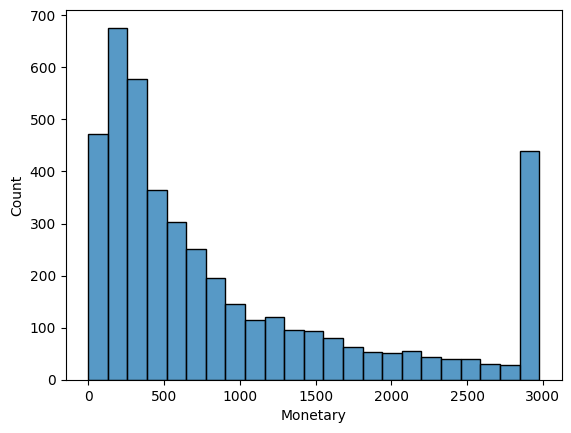

In [25]:
sns.histplot(data=df_or_train_rfm_clean, x='Monetary')

<Axes: xlabel='Recency', ylabel='Count'>

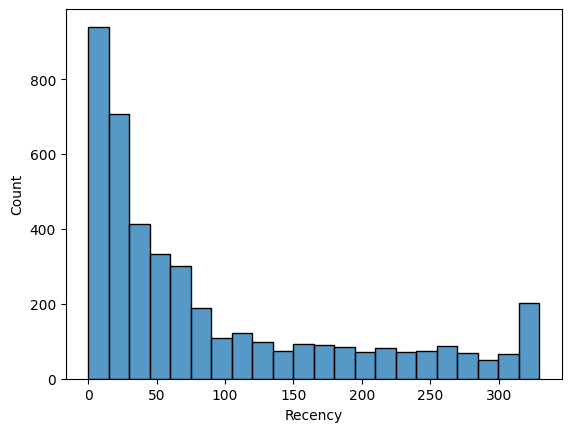

In [26]:
sns.histplot(data=df_or_train_rfm_clean, x='Recency')

### Scale the data

Apply `StandardScaler` on the features.

In [27]:
# YOUR CODE HERE for scaling
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

# Scaling Train data
cols = df_or_train_rfm_clean.select_dtypes(include=['int','float']).columns
df_or_train_rfm_scaled = std_scaler.fit_transform(df_or_train_rfm_clean[cols])
df_or_train_rfm_scaled = pd.DataFrame(df_or_train_rfm_scaled, columns=std_scaler.get_feature_names_out())



In [28]:
df_or_train_rfm_scaled

,Frequency,Monetary,Recency
0,-0.987740,-0.980590,2.402819
1,1.617469,2.221336,-0.919037
2,-0.604621,-0.487114,-0.170594
3,0.023694,0.328105,-0.744742
4,-0.757868,-0.691215,2.238777
...,...,...,...
4328,-0.849817,-0.821495,1.910692
4329,-0.895791,-0.943821,0.916186
4330,-0.834492,-0.861741,-0.857521
4331,2.268772,1.124136,-0.898532


<Axes: ylabel='Count'>

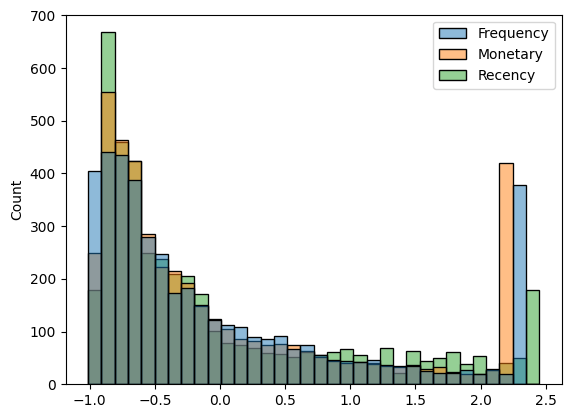

In [29]:
sns.histplot(data=df_or_train_rfm_scaled)

In [30]:
# Scaled and Encoded train data features converted to data frames
X = df_or_train_rfm_scaled
X

,Frequency,Monetary,Recency
0,-0.987740,-0.980590,2.402819
1,1.617469,2.221336,-0.919037
2,-0.604621,-0.487114,-0.170594
3,0.023694,0.328105,-0.744742
4,-0.757868,-0.691215,2.238777
...,...,...,...
4328,-0.849817,-0.821495,1.910692
4329,-0.895791,-0.943821,0.916186
4330,-0.834492,-0.861741,-0.857521
4331,2.268772,1.124136,-0.898532


In [31]:
X.isna().sum()

Frequency    0
Monetary     0
Recency      0
dtype: int64

In [32]:
# Scaled and Encoded test data features converted to data frames

## Clustering ( 5 points)

### Apply k-means algorithm to identify a specific number of clusters


* Fit the k-means model

* Extract and store the cluster centroids

Below are the parameters for k-means, which are helpful

**n_clusters** is no. of clusters specified

**k-means++** is a random initialization method for centroids to avoid random initialisation trap

**max_iter** is max no of iterations defined when k-means is running

**n_init** is no. of times k-means will run with different initial centroids

[why-is-k-means-slower-than-random-initialization-k-means](https://stats.stackexchange.com/questions/185396/why-is-k-means-slower-than-random-initialization-k-means/185422)

In [33]:
# Plot inertia by varying number of clusters - this is to find the optimal number of clusters
clusters = np.arange(1,10)
inertia = []
for c in clusters:
    kmeans = KMeans(n_clusters = c, init='k-means++', n_init=10, random_state=1)
    y_predict = kmeans.fit_predict(X)
    inertia.append(kmeans.inertia_)


[12999.000000000011, 6185.174346199901, 3213.6388115686004, 2400.0463313747596, 2047.6379838961334, 1728.738747167168, 1424.804447546599, 1302.125658817761, 1187.173556864861]



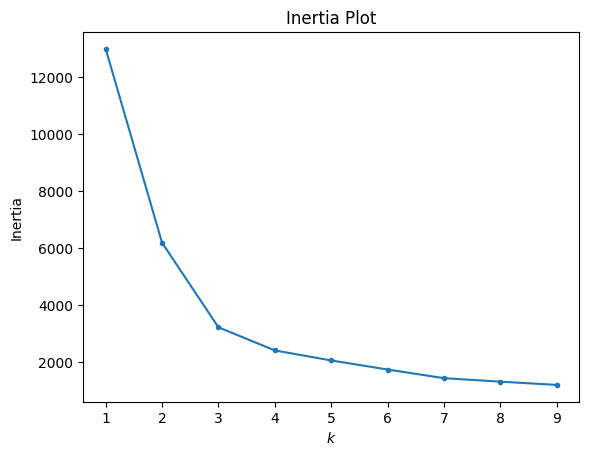

In [34]:
print(inertia)
print()
plt.plot(clusters, inertia, marker= '.')
# plt.arrow(5, 400, -2, -252)
# plt.text(5, 410, "Elbow", fontdict={'size': 12})
plt.title('Inertia Plot')
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.show()

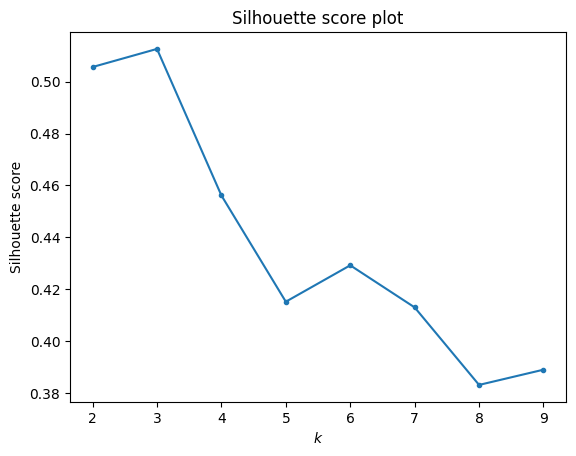

In [35]:
clusters = np.arange(2,10)
sil_score = []
for c in clusters:
    kmeans = KMeans(n_clusters = c, init='k-means++', n_init=10, random_state=1)
    kmeans.fit_predict(X)
    sil_score.append(silhouette_score(X, kmeans.labels_))
plt.plot(clusters, sil_score, marker= '.')
plt.title('Silhouette score plot')
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.show()

In [36]:
print(sil_score[1:])
max_idx = np.argmax(sil_score[1:])
n_clusters_opt = max_idx + 3
n_clusters_opt

[0.5126159871274812, 0.4561106244438114, 0.4151445114305452, 0.4291812838974755, 0.41295239959169844, 0.38306037819463734, 0.38893437410551074]


3

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


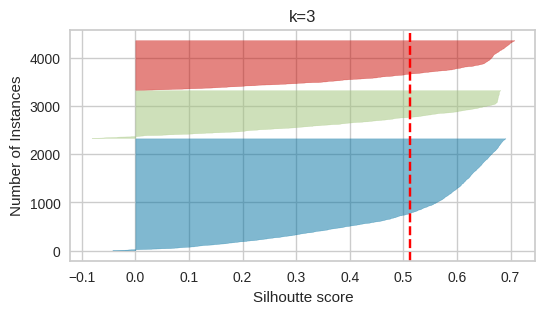

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


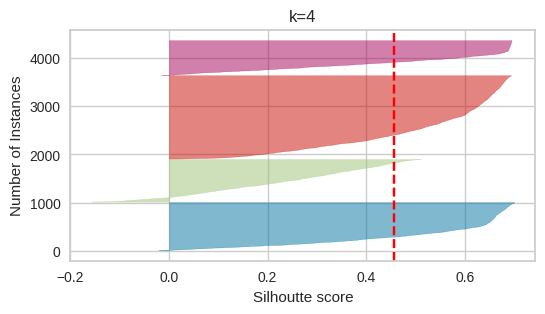

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


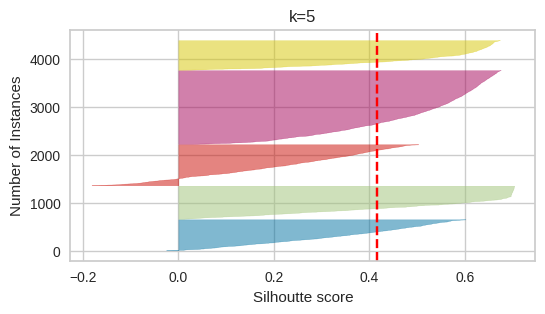

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


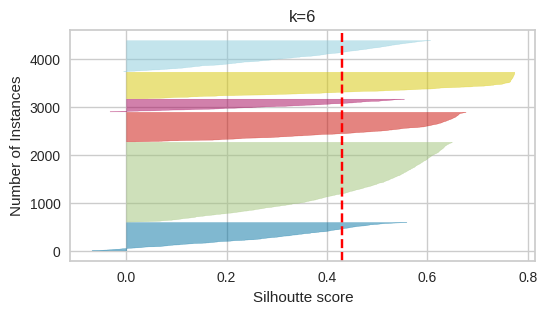

In [37]:
from yellowbrick.cluster import SilhouetteVisualizer

clusters = [3, 4, 5, 6]
for c in clusters:
    plt.figure(figsize=(6, 3))
    # Instantiate the clustering model and visualizer
    kmeans = KMeans(c, random_state=1)
    # Instantiate SilhouetteVisualizer()
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    # Fit the data to the visualizer
    visualizer.fit(X);
    plt.title("k={}".format(c))
    plt.xlabel("Silhoutte score")
    plt.ylabel("Number of Instances")
    plt.show()

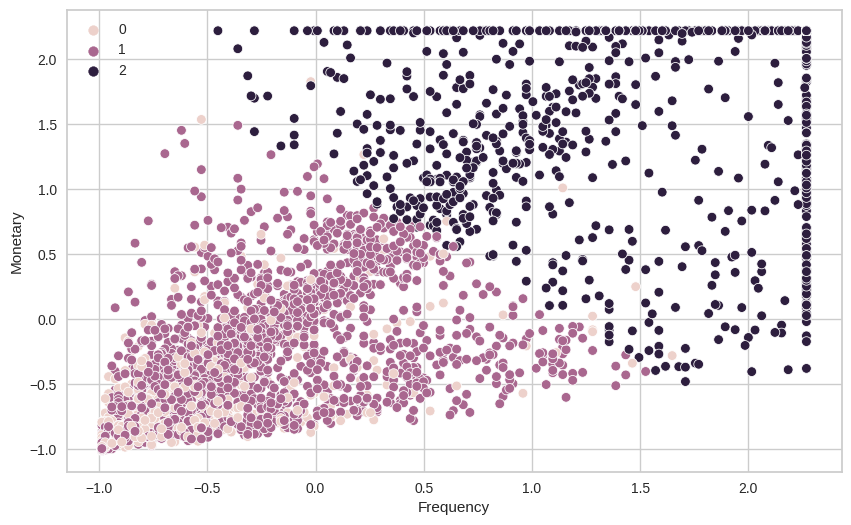

In [38]:
# YOUR CODE HERE to apply KMeans
kmeans = KMeans(n_clusters=n_clusters_opt, init='k-means++', n_init =10, random_state=42)
y_predict = kmeans.fit_predict(X)
cluster_centers_opt = kmeans.cluster_centers_
inertia_opt = kmeans.inertia_

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Frequency', y='Monetary', data=X, hue=y_predict)
plt.show()

In [39]:
# Get cluster labels
cluster_labels = kmeans.labels_

for cluster in range(n_clusters_opt):
    num_samples_in_cluster = np.sum(cluster_labels == cluster)
    print(f"Cluster {cluster}: {num_samples_in_cluster} samples")

Cluster 0: 1027 samples
Cluster 1: 2318 samples
Cluster 2: 988 samples


In [40]:
X_inverse = std_scaler.inverse_transform(X)
X_inverse = pd.DataFrame(X_inverse, columns=std_scaler.get_feature_names_out())
X_inverse

,Frequency,Monetary,Recency
0,1.0,28.080,325.0
1,171.0,2974.905,1.0
2,26.0,482.240,74.0
3,67.0,1232.510,18.0
4,16.0,294.400,309.0
...,...,...,...
4328,10.0,174.500,277.0
4329,7.0,61.920,180.0
4330,11.0,137.460,7.0
4331,213.5,1965.120,3.0


In [41]:
df_X_cluster = X_inverse.copy()
df_X_cluster['Cluster'] = cluster_labels
df_X_cluster

,Frequency,Monetary,Recency,Cluster
0,1.0,28.080,325.0,0
1,171.0,2974.905,1.0,2
2,26.0,482.240,74.0,1
3,67.0,1232.510,18.0,1
4,16.0,294.400,309.0,0
...,...,...,...,...
4328,10.0,174.500,277.0,0
4329,7.0,61.920,180.0,0
4330,11.0,137.460,7.0,1
4331,213.5,1965.120,3.0,2


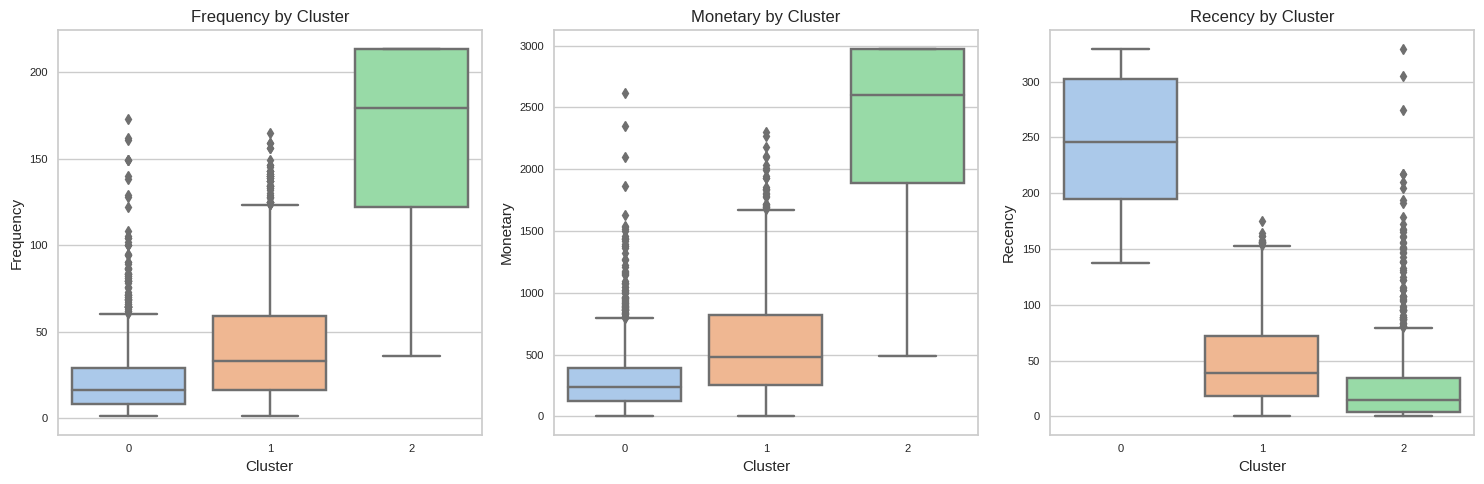

In [42]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
palette = sns.color_palette("pastel")

sns.boxplot(x="Cluster", y="Frequency", data=df_X_cluster, ax=axes[0], palette=palette)
sns.boxplot(x="Cluster", y="Monetary", data=df_X_cluster, ax=axes[1], palette=palette)
sns.boxplot(x="Cluster", y="Recency", data=df_X_cluster, ax=axes[2], palette=palette)
for ax in axes:
    ax.tick_params(axis='both', labelsize=8)
# Set titles for each subplot
axes[0].set_title("Frequency by Cluster")
axes[1].set_title("Monetary by Cluster")
axes[2].set_title("Recency by Cluster")

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

#### Find the optimal number of clusters (K) by using the [Elbow method](https://pythonprogramminglanguage.com/kmeans-elbow-method/).

Use the optimal no. of clusters and store the cluster centroids

In [43]:
# YOUR CODE HERE
print(f"The optimal number of clusters for K-means clustering : {n_clusters_opt}")
print(f"The clusters ceneters for K-means clustering : {cluster_centers_opt}")
print(f"The optimal inertia : {inertia_opt}")

The optimal number of clusters for K-means clustering : 3
The clusters ceneters for K-means clustering : [[-0.64917728 -0.66603848  1.59668892]
 [-0.37269797 -0.37343539 -0.43049608]
 [ 1.54532684  1.56454332 -0.64926322]]
The optimal inertia : 3213.656772637697


### Apply DBSCAN algorithm for clustering

- Compare the results of clusters from k-means and DBSCAN


In [44]:
# YOUR CODE HERE
dbscan = DBSCAN(eps=0.22, min_samples=5)
dbscan.fit(X)
print("Unique clusters in data: ", np.unique(dbscan.labels_))

Unique clusters in data:  [-1  0  1  2  3]


In [45]:
cluster_labels = dbscan.labels_

for cluster in np.unique(dbscan.labels_):
    num_samples_in_cluster = np.sum(cluster_labels == cluster)
    print(f"Cluster {cluster}: {num_samples_in_cluster} samples")


Cluster -1: 236 samples
Cluster 0: 4079 samples
Cluster 1: 5 samples
Cluster 2: 9 samples
Cluster 3: 4 samples


### Analyze the clusters


- consider two features and visualize the clusters with different colors using the predicted cluster centers.

  **Hint:** 2D plot

- consider three features and visualize the clusters with different colors using the predicted cluster centers.

  **Hint:** [3D plot](https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html
)

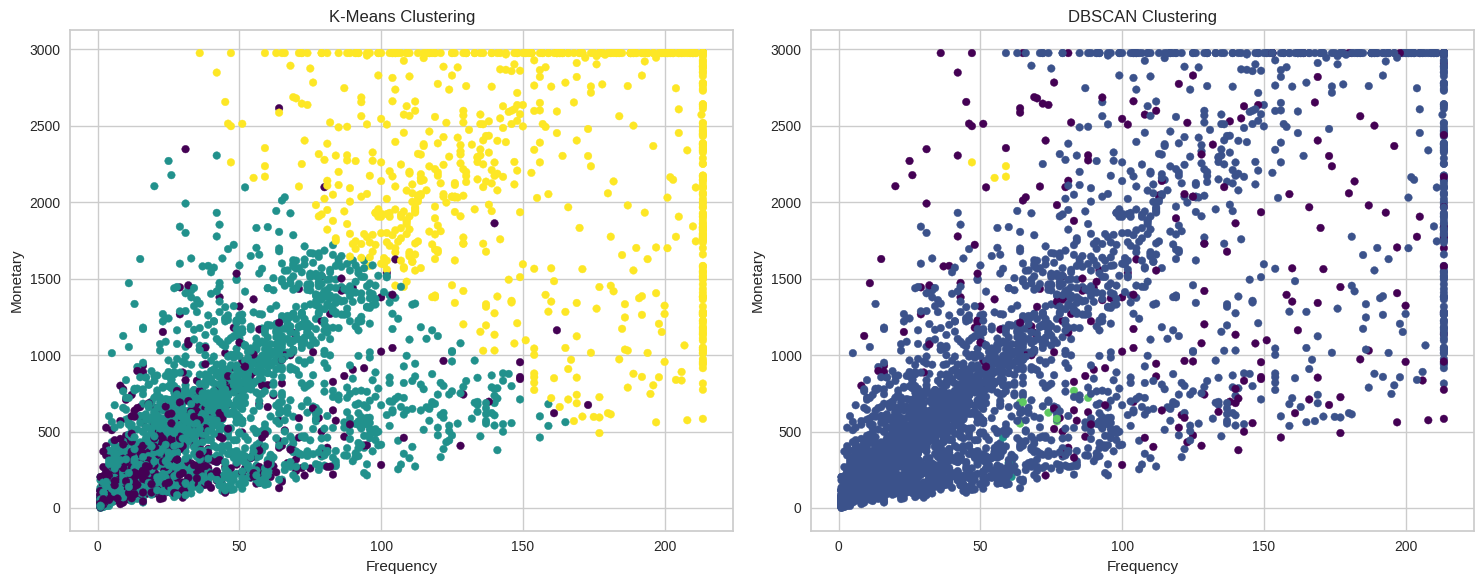

In [46]:
# Create a 2D plot
fig = plt.figure(figsize=(15, 6))

# K-Means results
ax1 = fig.add_subplot(121)
ax1.scatter(df_X_cluster['Frequency'], df_X_cluster['Monetary'], c=df_X_cluster['Cluster'], cmap='viridis', s=30)
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Monetary')
ax1.set_title('K-Means Clustering')
ax1.legend()

# DBSCAN results
ax2 = fig.add_subplot(122)
ax2.scatter(df_X_cluster['Frequency'], df_X_cluster['Monetary'], c=dbscan.labels_, cmap='viridis', s=30)
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Monetary')
ax2.set_title('DBSCAN Clustering')
ax1.legend()

plt.tight_layout()
plt.show()

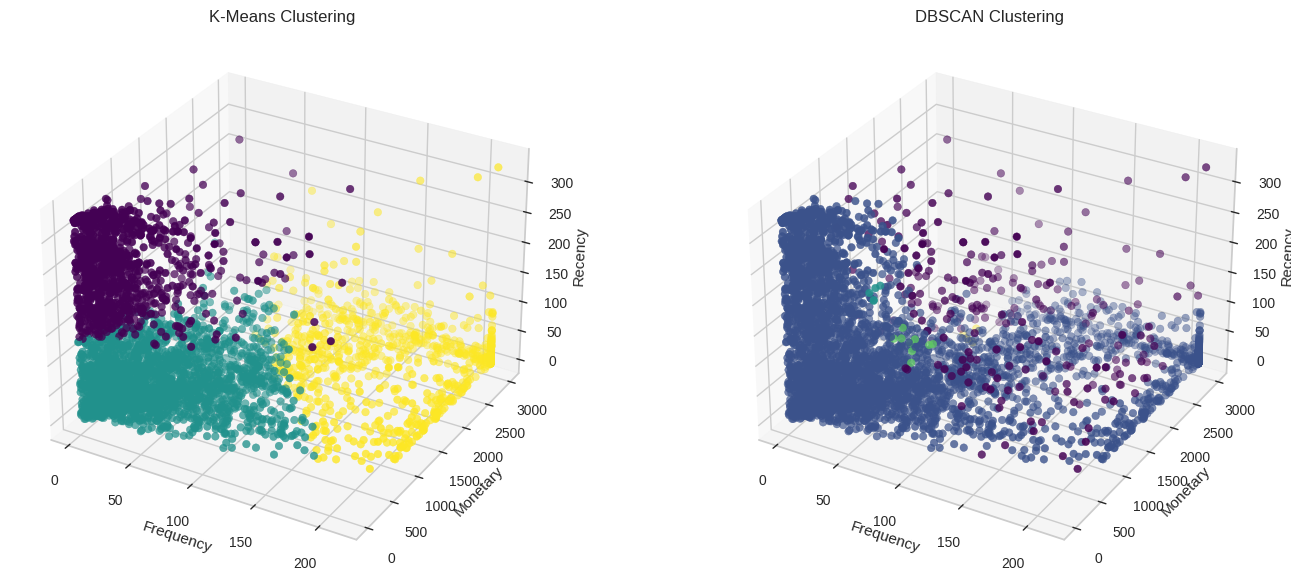

In [47]:
# YOUR CODE HERE
# Visualize data with DBSCAN labels
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Create a 3D plot
fig = plt.figure(figsize=(15, 6))

# K-Means results
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(df_X_cluster['Frequency'], df_X_cluster['Monetary'], df_X_cluster['Recency'], c=df_X_cluster['Cluster'], cmap='viridis', s=30)
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Monetary')
ax1.set_zlabel('Recency')
ax1.set_title('K-Means Clustering')

# DBSCAN results
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(df_X_cluster['Frequency'], df_X_cluster['Monetary'], df_X_cluster['Recency'], c=dbscan.labels_, cmap='viridis', s=30)
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Monetary')
ax2.set_zlabel('Recency')
ax2.set_title('DBSCAN Clustering')

plt.tight_layout()
plt.show()

### Train a supervised algorithm on clustered data

This will allow us to predict cluster numbers (label) for each test data instance

* Create labelled data with k-means cluster labels
  
  **Hint**: [`kmeans.labels_`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
)
* Split the data into train and validation sets
* Train a supervised algorithm on the train data
* Find the accuracy of the model using validation data

In [48]:
# X = df_or_train_rfm
y = kmeans.labels_
set(y)

{0, 1, 2}

In [49]:
# YOUR CODE HERE

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((3466, 3), (867, 3), (3466,), (867,))

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

rf_clf = RandomForestClassifier(n_estimators=300,           # number of trees in the forest
                                # max_leaf_nodes=16,          # grow trees with max_leaf_nodes, selected by
                                                            # relative reduction in impurity.
                                                            # If None, then unlimited number of leaf nodes
                                random_state= 42
                                )
rf_clf.fit(X_train, y_train)
y_pred_val = rf_clf.predict(X_val)
print(set(y_pred_val))
accuracy_score(y_val, y_pred_val)

{0, 1, 2}


0.986159169550173

### Evaluation of Test Data
* Use the model to predict the labels for the Test data below
* Format the test data in the same format as the train data.
* Predict it with trained supervised ML model

In [51]:
# Test set provided as below
df_test = pd.read_csv("Online_Retail_Test.csv")
df_test.head(3)

# YOUR CODE HERE
df_test = data_pre_process(df_test)
df_test = add_dayofweek(df_test)
df_test = cap_outliers('Quantity', df_test)
df_test = cap_outliers('UnitPrice', df_test)
df_test = add_new_features(df_test)
df_test = drop_unwanted_features(df_test)

df_test = df_test.groupby('CustomerID').agg({'CustomerID':'count','TotalAmountSpent':'sum','Recency':'min'})
df_test.rename(columns={'CustomerID': 'Frequency', 'TotalAmountSpent': 'Monetary'}, inplace=True)

df_test = cap_outliers('Recency', df_test)
df_test = cap_outliers('Frequency', df_test)
df_test = cap_outliers('Monetary', df_test)

df_test_scaled = std_scaler.transform(df_test)
df_test_scaled = pd.DataFrame(df_test_scaled, columns=std_scaler.get_feature_names_out())

X_test = df_test_scaled
y_pred_test = rf_clf.predict(X_test)
set(y_pred_test)

{0, 1}

In [52]:
X_test = std_scaler.inverse_transform(X_test)
X_test_inverse = pd.DataFrame(X_test, columns=std_scaler.get_feature_names_out())
X_test_inverse = np.round(X_test_inverse, 2)
X_test_inverse['Cluster'] = y_pred_test
X_test_inverse

,Frequency,Monetary,Recency,Cluster
0,11.0,213.70,1.0,1
1,1.0,7.83,318.0,0
2,5.0,96.64,18.0,1
3,2.0,45.00,203.0,0
4,3.0,31.00,231.0,0
...,...,...,...,...
3302,10.0,172.00,2.0,1
3303,1.0,17.55,43.0,1
3304,1.0,13.50,125.0,1
3305,12.0,110.91,3.0,1


### Report Analysis

- Discuss the pros and cons of removing the missing values vs replacing with the mean values
- Based on the visualization of clusters, comment on the difference in buying patterns of each cluster
- What other methods could be used to determine the optimal no. of clusters?